## Sensitivity Analysis for Global Seed

This jupyter notebook creates plots to study the impact of varying the global seed for base-case analysis

### 0. Analysis IDs to compare

In [29]:
# Define the set id for the analysis_ids that we want to compare
set_id  = (118, )

### 1. Package Installs

In [30]:
# python-dtenv to read the env variables
#!pip install python-dotenv

In [31]:
# Seaborn for plotting
#!pip install seaborn

In [32]:
# Plotly for plotting 
#!pip install plotly

In [33]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from dotenv import load_dotenv
from pathlib import Path  # Python 3.6+ only
import os
import psycopg2
from plotly import graph_objects as go
from plotly.subplots import make_subplots
import numpy as np
import plotly.express as px

### 2. Environment Variables

In [34]:
# Load the environment variables
env_path = Path('..') / '.env'
load_dotenv(dotenv_path=env_path)

True

In [35]:
# Print this to see if the env variables are read now
os.getenv("COMPOSE_PROJECT_NAME")

'chargeval_dev'

### 3. Database connection

In [36]:
# Generic function to test the connection to the database
def connect():
    """ Connect to the PostgreSQL database server """
    conn = None
    try:

        # connect to the PostgreSQL server
        print('Connecting to the PostgreSQL database...')
        conn = psycopg2.connect(    
            host=os.getenv("MAIN_HOST"),
            database=os.getenv("MAIN_DB"),
            user=os.getenv("DBREAD_USER"),
            password=os.getenv("DBREAD_PWD"), 
            port = os.getenv("MAIN_PORT")
        )
		
        # create a cursor
        cur = conn.cursor()
        
	# execute a statement
        print('PostgreSQL database version:')
        cur.execute('SELECT version()')

        # display the PostgreSQL database server version
        db_version = cur.fetchone()
        print(db_version)
       
	# close the communication with the PostgreSQL
        cur.close()
    except (Exception, psycopg2.DatabaseError) as error:
        print(error)
    finally:
        if conn is not None:
            conn.close()
            print('Database connection closed.')

In [37]:
# Make the test database connection
connect()

Connecting to the PostgreSQL database...
PostgreSQL database version:
('PostgreSQL 12.5 on x86_64-pc-linux-gnu, compiled by gcc (GCC) 4.8.5 20150623 (Red Hat 4.8.5-11), 64-bit',)
Database connection closed.


In [38]:
conn = psycopg2.connect(    
    host=os.getenv("MAIN_HOST"),
    database=os.getenv("MAIN_DB"),
    user=os.getenv("DBREAD_USER"),
    password=os.getenv("DBREAD_PWD"), 
    port = os.getenv("MAIN_PORT")
)

# create a cursor
cur = conn.cursor()

### 4. Database queries

In [39]:
cur.execute('select count(veh_id) from wa_bevs')
evs_in_wa = cur.fetchone()
evs_in_wa

(46727,)

In [40]:
sql_evs_in_sim = 'select count(veh_id), analysis_id from evtrip_scenarios where analysis_id IN (select analysis_id from analysis_record where set_id IN %s) group by analysis_id;'
# cur.mogrify(sql_evs_in_sim, (analysis_ids,))
evs_in_sim = pd.read_sql_query(sql=sql_evs_in_sim, con=conn, params=(set_id,))
evs_in_sim

,count,analysis_id
0,441,627
1,397,628
2,386,629
3,431,630
4,392,631
5,402,632
6,457,633
7,415,634
8,414,635
9,440,636


In [41]:
sql_evs_fin = 'select count(veh_id), analysis_id from ev_finished where analysis_id IN (select analysis_id from analysis_record where set_id IN %s) group by analysis_id;'
# cur.mogrify(sql_evs_fin, (analysis_ids,))
evs_fin = pd.read_sql_query(sql=sql_evs_fin, con=conn, params=(set_id,))
evs_fin

,count,analysis_id
0,441,627
1,397,628
2,386,629
3,422,630
4,392,631
5,402,632
6,416,633
7,414,634
8,414,635
9,377,636


In [42]:
sql_evs_str = 'select count(veh_id), analysis_id from ev_stranded where analysis_id IN (select analysis_id from analysis_record where set_id IN %s) group by analysis_id;'
# cur.mogrify(sql_evs_str, (analysis_ids,)) # Uncomment for debugging the query
evs_str = pd.read_sql_query(sql=sql_evs_str, con=conn, params=(set_id,))
evs_str

,count,analysis_id
0,1,641
1,1,634
2,1,650
3,1,644
4,2,636
5,1,643
6,2,640
7,1,651
8,1,645
9,2,633


In [43]:
sql_evs_str_loc = '''select stranded_lat, stranded_lng, est.analysis_id, ap.param_value as global_seed
from ev_stranded est
         join (
    select param_value, analysis_id
    from analysis_params
    where param_id = 1) as ap
              on est.analysis_id = ap.analysis_id
where est.analysis_id IN (select analysis_id from analysis_record where set_id IN %s)
ORDER BY global_seed;'''
evs_str_loc = pd.read_sql_query(sql=sql_evs_str_loc, con=conn, params=(set_id,))
evs_str_loc.head()

,stranded_lat,stranded_lng,analysis_id,global_seed
0,47.612636,-119.831964,633,140
1,47.276438,-122.559991,633,140
2,47.844227,-119.975629,636,17
3,46.363166,-119.385871,636,17
4,47.467964,-120.337767,649,240


In [44]:
sql_evmt = 'select sum(distance_travelled), analysis_id from ev_finished where analysis_id IN (select analysis_id from analysis_record where set_id IN %s) group by analysis_id;'
# cur.mogrify(sql_evmt, (analysis_ids,))
evmt = pd.read_sql_query(sql=sql_evmt, con=conn, params=(set_id,))
evmt

,sum,analysis_id
0,43978.0,627
1,39159.0,628
2,38245.0,629
3,41608.0,630
4,38634.0,631
5,39307.0,632
6,41233.0,633
7,40012.0,634
8,40682.0,635
9,37143.0,636


In [45]:
sql_cs = 'select count(cs_id), analysis_id from evse_charging_session where analysis_id IN (select analysis_id from analysis_record where set_id IN %s) group by analysis_id;'
# cur.mogrify(sql_cs, (analysis_ids,))
cs = pd.read_sql_query(sql=sql_cs, con=conn, params=(set_id,))
cs

,count,analysis_id
0,94,627
1,74,628
2,75,629
3,99,630
4,84,631
5,88,632
6,104,633
7,87,634
8,94,635
9,64,636


In [46]:
sql_ws = 'select count(wait_id), analysis_id from evse_evs_waiting where analysis_id IN (select analysis_id from analysis_record where set_id IN %s) group by analysis_id;'
# cur.mogrify(sql_ws, (analysis_ids,))
ws = pd.read_sql_query(sql=sql_ws, con=conn, params=(set_id,))
ws

,count,analysis_id
0,1,641
1,2,638
2,2,634
3,2,632
4,1,650
5,2,644
6,1,631
7,1,643
8,1,651
9,1,627


In [47]:
sql_evse_util = """SELECT epd.analysis_id,
       epd.simulation_ts::timestamp as datetime,
       sum(epd.power_val)           as total_power,
       ap.param_value               as global_seed
FROM evse_power_draw epd
         join (select param_value, analysis_id from analysis_params where param_id = 1) as ap
              on epd.analysis_id = ap.analysis_id
WHERE epd.analysis_id IN (select analysis_id from analysis_record where set_id IN %s)
GROUP BY epd.simulation_ts, epd.analysis_id, ap.param_value
ORDER BY global_seed, epd.simulation_ts::timestamp;"""
# cur.mogrify(sql_evse_util, (analysis_ids,))
evse_util = pd.read_sql_query(sql=sql_evse_util, con=conn, params=(set_id,))
evse_util

,analysis_id,datetime,total_power,global_seed
0,633,2019-07-01 06:00:35,0,140
1,633,2019-07-01 06:01:35,0,140
2,633,2019-07-01 06:02:35,0,140
3,633,2019-07-01 06:03:35,0,140
4,633,2019-07-01 06:04:35,0,140
...,...,...,...,...
26588,628,2019-07-01 21:31:59,0,993
26589,628,2019-07-01 21:32:59,0,993
26590,628,2019-07-01 21:33:59,0,993
26591,628,2019-07-01 21:34:59,0,993


In [48]:
sql_count_stats = """select count(ets.veh_id) as sim_count,
       ets.analysis_id,
       ap.param_value,
       ef.fin_count,
       ef.evmt,
       es.str_count,
       ecs.cs_count,
       ew.wait_count
from evtrip_scenarios ets
         join (select param_value, analysis_id from analysis_params where param_id = 1) as ap
              on ets.analysis_id = ap.analysis_id
         join (select count(veh_id) as fin_count, sum(distance_travelled) as evmt, analysis_id
               from ev_finished
               group by analysis_id) as ef
              on ets.analysis_id = ef.analysis_id
         join (select count(veh_id) as str_count, analysis_id from ev_stranded group by analysis_id) as es
              on ets.analysis_id = es.analysis_id
         join (select count(cs_id) as cs_count, analysis_id from evse_charging_session group by analysis_id) as ecs
              on ets.analysis_id = ecs.analysis_id
join (select count(wait_id) as wait_count, analysis_id from evse_evs_waiting group by analysis_id) as ew
              on ets.analysis_id = ew.analysis_id
where ets.analysis_id IN (select analysis_id from analysis_record where set_id IN %s)
group by ets.analysis_id, ap.param_value, ef.fin_count, es.str_count, ef.evmt, ecs.cs_count, ew.wait_count
;"""
count_stats = pd.read_sql_query(sql=sql_count_stats, con=conn, params=(set_id,))
count_stats

,sim_count,analysis_id,param_value,fin_count,evmt,str_count,cs_count,wait_count
0,412,649,240,411,41259.0,1,76,4
1,421,641,722,420,41427.0,1,83,1
2,415,634,785,414,40012.0,1,87,2
3,412,650,644,411,40248.0,1,92,1
4,431,644,800,430,42668.0,1,89,2
5,442,643,956,441,42789.0,1,81,1
6,418,654,380,417,41529.0,1,88,1
7,443,651,548,442,44488.0,1,88,1


In [49]:
count_stats.dtypes
count_stats = count_stats.sort_values(by=['param_value'])
count_stats

,sim_count,analysis_id,param_value,fin_count,evmt,str_count,cs_count,wait_count
0,412,649,240,411,41259.0,1,76,4
6,418,654,380,417,41529.0,1,88,1
7,443,651,548,442,44488.0,1,88,1
3,412,650,644,411,40248.0,1,92,1
1,421,641,722,420,41427.0,1,83,1
2,415,634,785,414,40012.0,1,87,2
4,431,644,800,430,42668.0,1,89,2
5,442,643,956,441,42789.0,1,81,1


In [50]:
sql_comp_stats = """select lai.action_tstamp_tx                                               as start_time,
       lau.aid,
       lau.action_tstamp_tx                                               as end_time_tripgen,
       las.action_tstamp_tx,
       '# EV: ' || es.ev_count as ev_count,
       ap.param_value,
       ((DATE_PART('day', lau.action_tstamp_tx - lai.action_tstamp_tx) * 24 +
         DATE_PART('hour', lau.action_tstamp_tx - lai.action_tstamp_tx)) * 60 +
        DATE_PART('minute', lau.action_tstamp_tx - lai.action_tstamp_tx)) as time_taken_tripgen,
       ((DATE_PART('day', las.action_tstamp_tx - lau.action_tstamp_tx) * 24 +
         DATE_PART('hour', las.action_tstamp_tx - lau.action_tstamp_tx)) * 60 +
        DATE_PART('minute', las.action_tstamp_tx - lau.action_tstamp_tx)) as time_taken_eviabm
from audit.logged_actions lai
         join (select action_tstamp_tx, action, row_data -> 'analysis_id' as aid
               from audit.logged_actions
               where action = 'U'
                 and changed_fields -> 'status' LIKE 'trips_generated') as lau
              on lau.aid = lai.row_data -> 'analysis_id'
         join (select action_tstamp_tx, action, row_data -> 'analysis_id' as aid
               from audit.logged_actions
               where action = 'U'
                 and changed_fields -> 'status' LIKE 'solved') as las
              on las.aid = lai.row_data -> 'analysis_id'
         join (select count(veh_id) as ev_count, analysis_id from public.evtrip_scenarios group by analysis_id) as es
              on es.analysis_id = (lai.row_data -> 'analysis_id')::int
         join (select param_value, analysis_id from analysis_params where param_id = 1) as ap
              on (lai.row_data -> 'analysis_id')::int = ap.analysis_id
where lai.action = 'I'
  and lai.row_data -> 'analysis_id' ~* (select string_agg(cast(analysis_id as text), '|') from analysis_record where set_id IN %s)
ORDER BY ap.param_value
;"""
# data = '|'.join(map(str,set_id))
comp_stats = pd.read_sql_query(sql=sql_comp_stats, con=conn, params=(set_id,))
comp_stats

,start_time,aid,end_time_tripgen,action_tstamp_tx,ev_count,param_value,time_taken_tripgen,time_taken_eviabm
0,2021-04-20 23:28:21.148189+00:00,633,2021-04-21 00:20:53.890988+00:00,2021-04-21 01:32:47.461918+00:00,# EV: 457,140,52.0,71.0
1,2021-04-20 23:29:20.946152+00:00,652,2021-04-21 00:20:32.259090+00:00,2021-04-21 01:31:20.075642+00:00,# EV: 432,152,51.0,70.0
2,2021-04-20 23:28:30.596686+00:00,636,2021-04-21 00:21:28.311734+00:00,2021-04-21 01:35:34.004929+00:00,# EV: 440,17,52.0,74.0
3,2021-04-20 23:28:36.887302+00:00,638,2021-04-21 00:21:07.435104+00:00,2021-04-21 01:32:57.973860+00:00,# EV: 447,24,52.0,71.0
4,2021-04-20 23:29:11.513223+00:00,649,2021-04-21 00:21:03.865040+00:00,2021-04-21 01:20:56.414717+00:00,# EV: 412,240,51.0,59.0
5,2021-04-20 23:28:58.923135+00:00,645,2021-04-21 00:21:28.231489+00:00,2021-04-21 01:32:07.837243+00:00,# EV: 464,307,52.0,70.0
6,2021-04-20 23:28:33.742247+00:00,637,2021-04-21 00:20:21.531105+00:00,2021-04-21 01:25:32.249825+00:00,# EV: 423,373,51.0,65.0
7,2021-04-20 23:29:27.237746+00:00,654,2021-04-21 00:20:30.927101+00:00,2021-04-21 01:28:44.121096+00:00,# EV: 418,380,51.0,68.0
8,2021-04-20 23:29:08.370256+00:00,648,2021-04-21 00:21:24.961643+00:00,2021-04-21 01:32:13.220821+00:00,# EV: 441,517,52.0,70.0
9,2021-04-20 23:29:17.801314+00:00,651,2021-04-21 00:20:12.951129+00:00,2021-04-21 01:30:05.851685+00:00,# EV: 443,548,50.0,69.0


### 5. Plotting

#### 5.1 Vehicle Counts

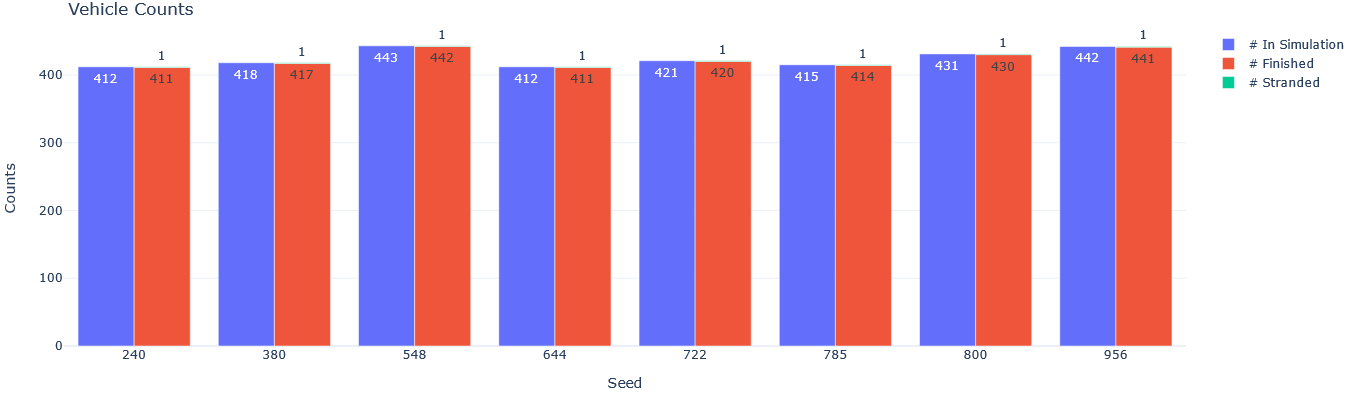

In [51]:
fig = go.Figure(
    data=[
        go.Bar(
            name="# In Simulation",
            x=count_stats['param_value'],
            y=count_stats['sim_count'],
            offsetgroup=0,
            text=count_stats['sim_count'],
            textposition='auto',
        ),
        go.Bar(
            name="# Finished",
            x=count_stats['param_value'],
            y=count_stats['fin_count'],
            offsetgroup=1,
            text=count_stats['fin_count'],
            textposition='auto',
        ),
        go.Bar(
            name="# Stranded",
            x=count_stats['param_value'],
            y=count_stats['str_count'],
            offsetgroup=1,
            base=count_stats['fin_count'],
            text=count_stats['str_count'],
            textposition='auto',
        )
    ],
    layout=go.Layout(
        title="Vehicle Counts",
        yaxis_title="Counts", 
        xaxis_title="Seed", width=600, height=400
        
    )
)
fig.update_xaxes(type='category')
fig.update_layout(margin=dict(l=20, r=20, t=30, b=20), uniformtext_minsize=8, uniformtext_mode='hide', template='plotly_white')
fig.show()

#### 5.2 eVMT

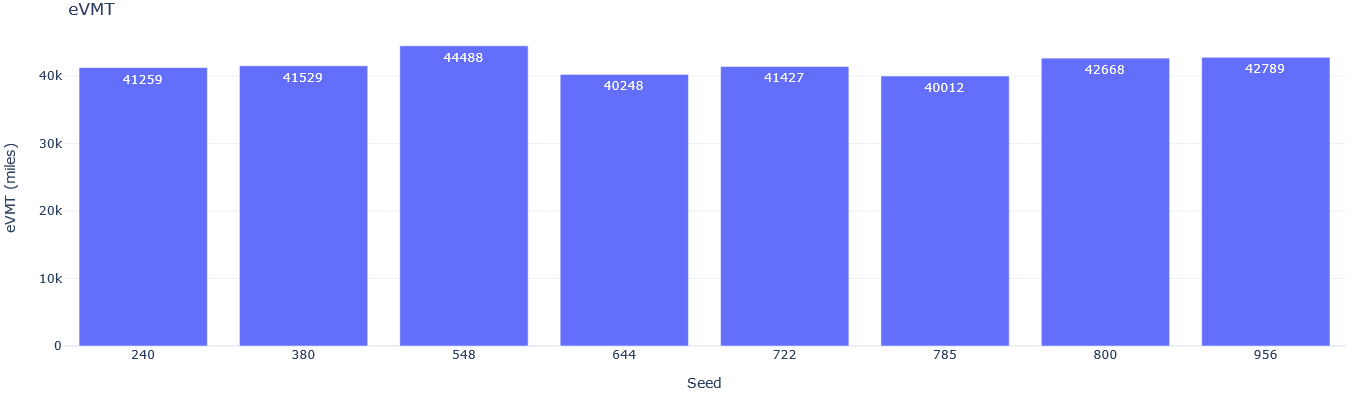

In [52]:
fig = go.Figure(
    data=[
        go.Bar(
            name="eVMT",
            x=count_stats['param_value'],
            y=count_stats['evmt'],
            offsetgroup=1,
            text=count_stats['evmt'],
            textposition='auto',
        )
    ],
    layout=go.Layout(
        title="eVMT",
        yaxis_title="eVMT (miles)", 
        xaxis_title="Seed", uniformtext_minsize=8, uniformtext_mode='hide', width=400, height=400
        
    )
)
fig.update_xaxes(type='category')

fig.update_layout(margin=dict(l=20, r=20, t=30, b=20), uniformtext_minsize=8, uniformtext_mode='hide', template='plotly_white')
fig.show()

#### 5.3 Charging and Waiting Sessions

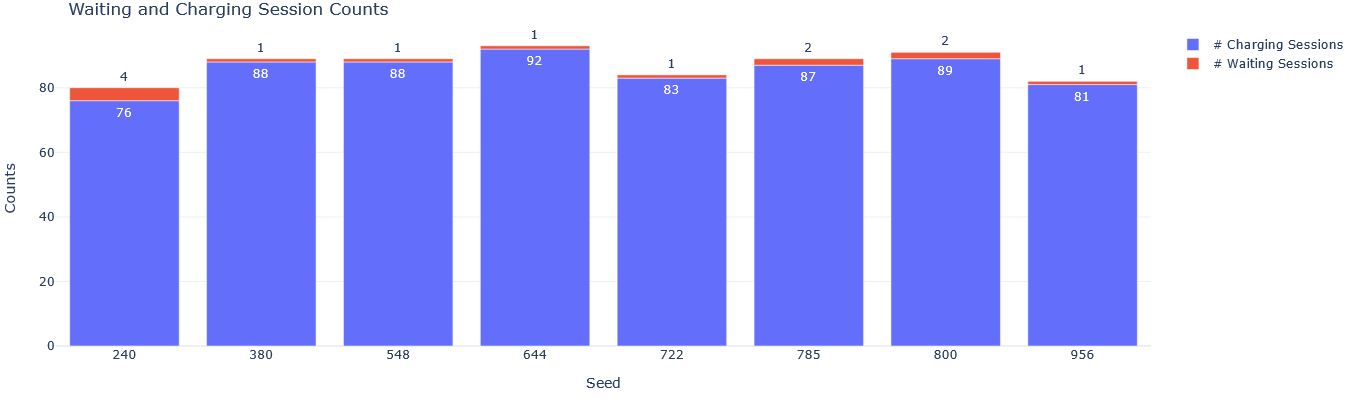

In [53]:
fig = go.Figure(
    data=[
        go.Bar(
            name="# Charging Sessions",
            x=count_stats['param_value'],
            y=count_stats['cs_count'],
            offsetgroup=1,
            text=count_stats['cs_count'],
            textposition='auto',
        ),
        go.Bar(
            name="# Waiting Sessions",
            x=count_stats['param_value'],
            y=count_stats['wait_count'],
            offsetgroup=1,
            base=count_stats['cs_count'],
            text=count_stats['wait_count'],
            textposition='auto',
        )
    ],
    layout=go.Layout(
        title="Waiting and Charging Session Counts",
        yaxis_title="Counts", 
        xaxis_title="Seed", width=600, height=400
        
    )
)
fig.update_xaxes(type='category')
fig.update_layout(margin=dict(l=20, r=20, t=30, b=20), uniformtext_minsize=8, uniformtext_mode='hide', template='plotly_white')
fig.show()

#### 5.4 EVSE Utilization

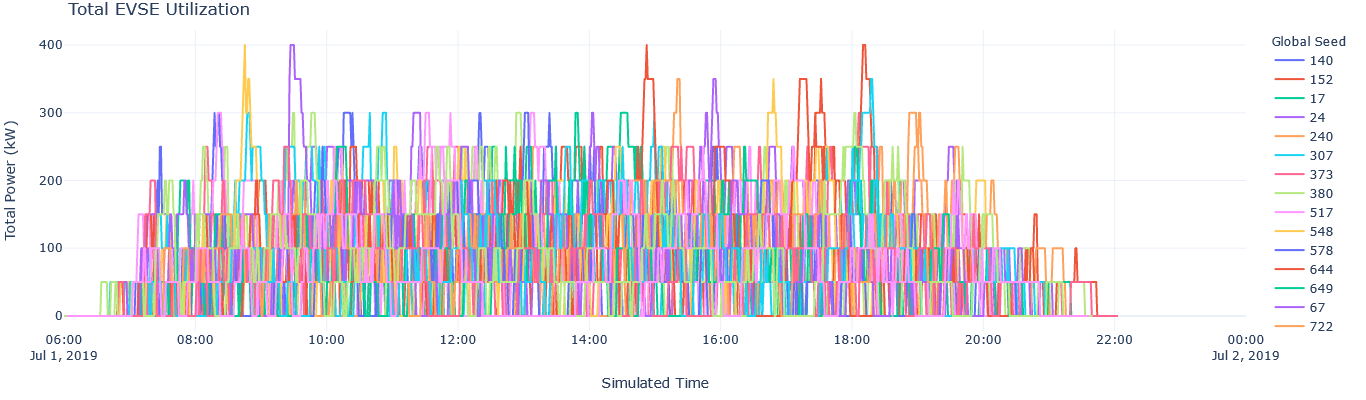

In [54]:
fig = px.line(evse_util, x="datetime", y="total_power", color='global_seed', labels={"global_seed": 'Global Seed'}, range_x=['2019-07-01 06:00','2019-07-02'])
fig.update_layout(title="Total EVSE Utilization",
                  yaxis_title="Total Power (kW)", 
                  xaxis_title="Simulated Time", 
                  uniformtext_minsize=8, 
                  uniformtext_mode='hide', 
                  width=1000, 
                  height=400, 
                  margin=dict(l=20, r=20, t=30, b=20), template='plotly_white')
fig.show()

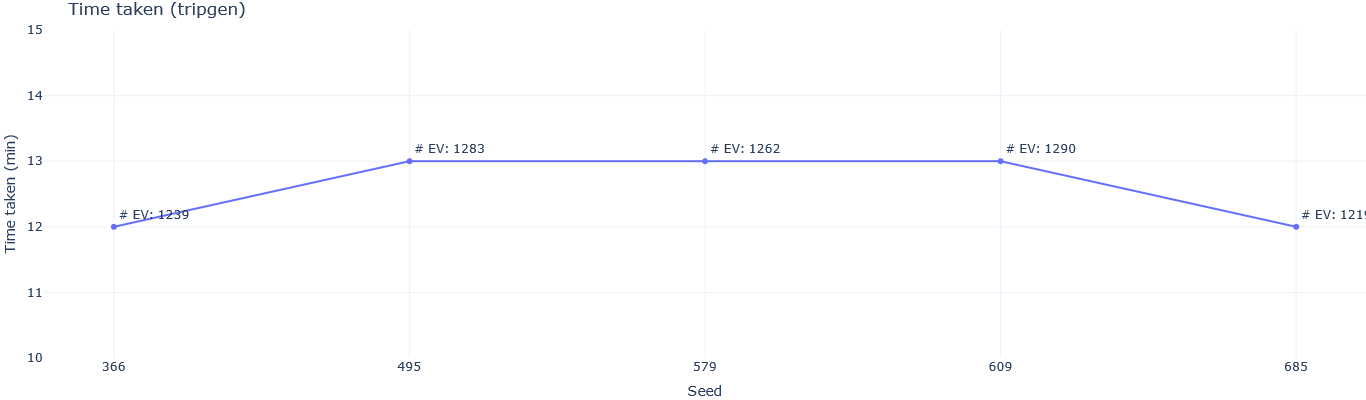

In [30]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=comp_stats['param_value'], y=comp_stats['time_taken_tripgen'],
                         mode='lines+markers+text',
                         name='lines+markers', 
                         text=comp_stats['ev_count'],
                         textposition="top right"))
fig.update_xaxes(type='category', automargin=True)
fig.update_yaxes(range=(10, 15))
fig.update_layout(title="Time taken (tripgen)",
                  yaxis_title="Time taken (min)", 
                  xaxis_title="Seed", 
                  uniformtext_minsize=8, 
                  uniformtext_mode='hide', 
                  width=400, 
                  height=400, 
                  margin=dict(l=20, r=0, t=30, b=20),
                 template='plotly_white')
fig.show()

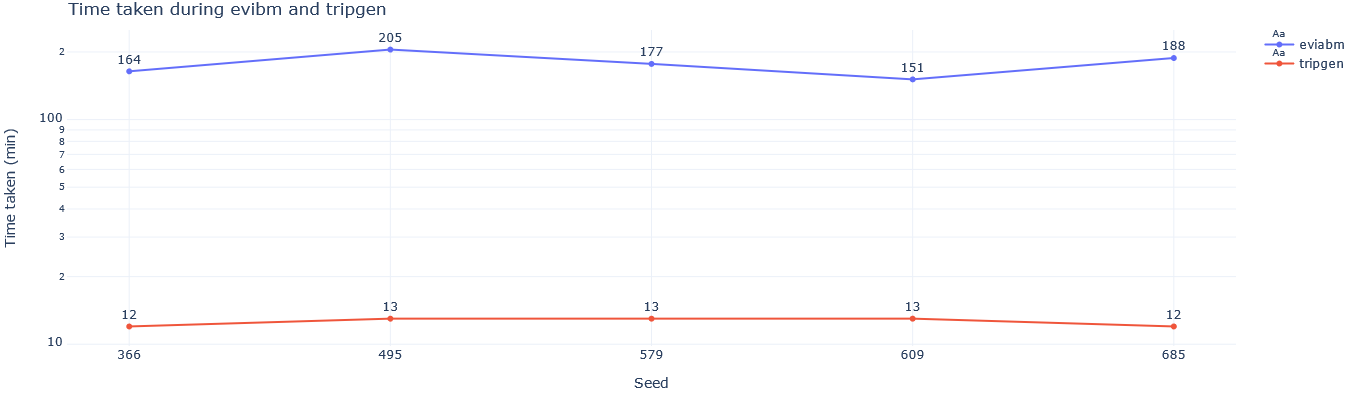

In [31]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=comp_stats['param_value'], y=comp_stats['time_taken_eviabm'],
                    mode='lines+markers+text',
                    name='eviabm', text=comp_stats['time_taken_eviabm'],
                    textposition="top center"))
fig.add_trace(go.Scatter(x=comp_stats['param_value'], y=comp_stats['time_taken_tripgen'],
                         mode='lines+markers+text',
                         name='tripgen', text=comp_stats['time_taken_tripgen'],
                         textposition="top center"))
fig.update_xaxes(type='category')
fig.update_yaxes( type="log")
fig.update_layout(title="Time taken during evibm and tripgen",
                  yaxis_title="Time taken (min)", 
                  xaxis_title="Seed", 
                  uniformtext_minsize=8, 
                  uniformtext_mode='hide', 
                  width=600, 
                  height=400, 
                  margin=dict(l=20, r=20, t=30, b=20),
                  template='plotly_white')
fig.show()

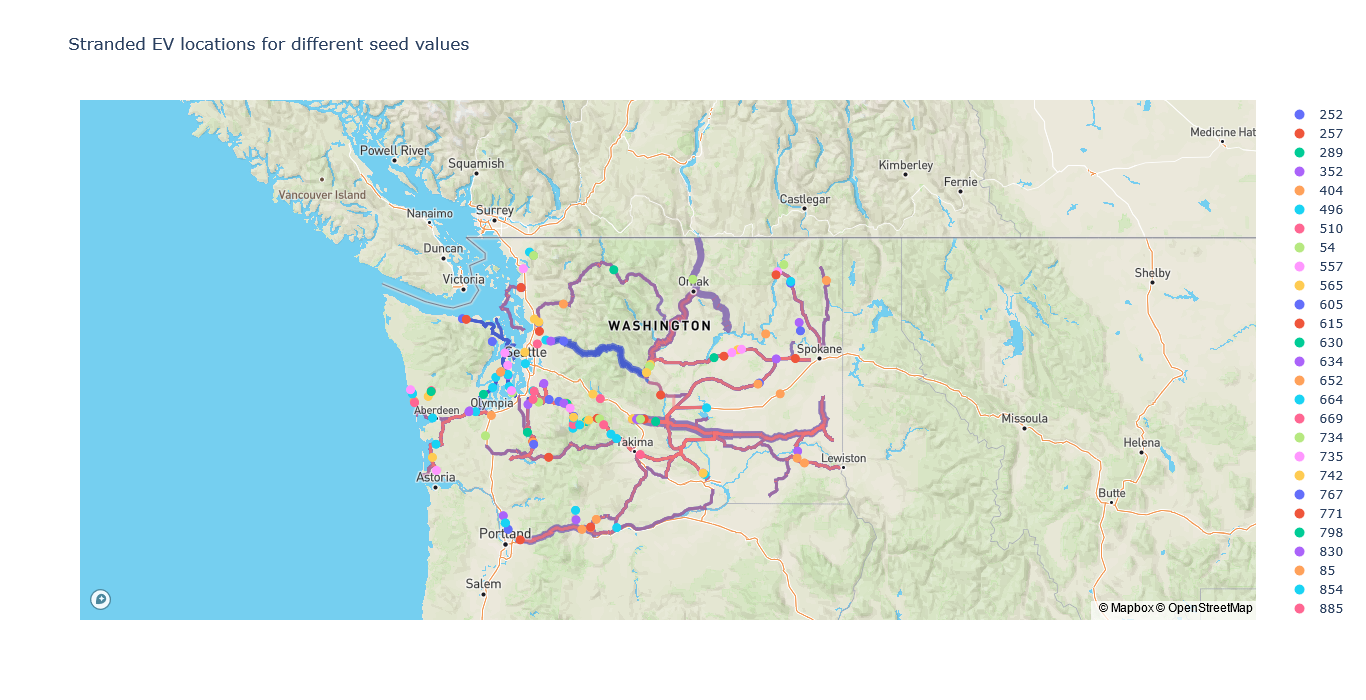

In [28]:
fig = go.Figure()
token = os.getenv("MAPBOX_ACCESS_TOKEN")
for seed in evs_str_loc['global_seed'].unique():
    fig.add_trace(go.Scattermapbox(
            lat=evs_str_loc[evs_str_loc['global_seed'] == seed]['stranded_lat'],
            lon=evs_str_loc[evs_str_loc['global_seed'] == seed]['stranded_lng'],
            mode='markers',
            marker=go.scattermapbox.Marker(
                size=10
            ), 
            name = seed
        ))

fig.update_layout(
        title_text = 'Stranded EV locations for different seed values',
        showlegend = True,
        mapbox_style="mapbox://styles/chintanp/ckhmnh3oa01r419pkc9qgn0sq", mapbox_accesstoken=token,
        mapbox_zoom=6, mapbox_center = {"lat":  47.7511, "lon": -120.7401}, 
        width=1000, 
        height=700
    )

fig.show()

____________
____________

Things to do the first time if the plotly plots not showing. Restart jupyter lab after. 

In [34]:
#!jupyter labextension list

In [35]:
#!jupyter labextension uninstall jupyterlab-plotly

In [36]:
#!jupyter labextension uninstall plotlywidget

In [37]:
#!export NODE_OPTIONS=--max-old-space-size=4096

In [38]:
#!pip show plotly

In [39]:
#!pip install jupyterlab "ipywidgets>=7.5"

In [40]:
#!jupyter labextension install jupyterlab-plotly@4.12.0

In [41]:
#!jupyter labextension install @jupyter-widgets/jupyterlab-manager plotlywidget@4.12.0

In [42]:
#!pip install "nbconvert<6"